In [44]:
import pandas as pd

df = pd.read_csv("stromverbrauch_stadtwerke.csv", sep=",")

df =df.head(n=100)
df

,Zeit,kW,Status,Kunde
0,2020-01-01T00:15:00Z,1954.4,W,1
1,2020-01-01T00:30:00Z,1943.2,W,1
2,2020-01-01T00:45:00Z,1996.8,W,1
3,2020-01-01T01:00:00Z,1961.4,W,1
4,2020-01-01T01:15:00Z,1958.2,W,1
...,...,...,...,...
95,2020-01-02T00:00:00Z,1939.6,W,1
96,2020-01-02T00:15:00Z,1993.6,W,1
97,2020-01-02T00:30:00Z,2037.8,W,1
98,2020-01-02T00:45:00Z,2029.2,W,1


In [45]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [89]:
# fix random seed for reproducibility
tf.random.set_seed(7)

# load the dataset
dataframe = pd.read_csv('stromverbrauch_stadtwerke.csv', engine='python')

dataframe = dataframe.drop(dataframe[dataframe["Kunde"]==1].index)

dataset = dataframe[["kW"]]

In [90]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [91]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))


128120 63104


In [92]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [93]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [94]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [ ]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=10, batch_size=1, verbose=2)

Epoch 1/10
128118/128118 - 229s - loss: 3.3246e-04 - 229s/epoch - 2ms/step
Epoch 2/10
128118/128118 - 233s - loss: 1.1358e-04 - 233s/epoch - 2ms/step
Epoch 3/10
128118/128118 - 224s - loss: 1.1202e-04 - 224s/epoch - 2ms/step
Epoch 4/10
128118/128118 - 225s - loss: 1.0983e-04 - 225s/epoch - 2ms/step
Epoch 5/10


In [53]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

1/1 [==============================] - 0s 27ms/step
Train Score: 47.70 RMSE
Test Score: 40.34 RMSE


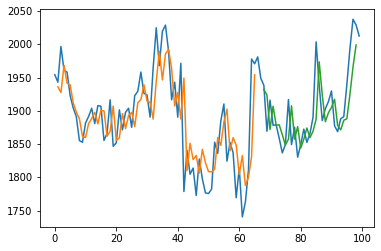

In [54]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()